# 데이터 전처리 (Preprocessing)

## 목표
- 3개 데이터셋 통합
- 결측값(SV) 처리
- 기본 타겟 변수 생성
- 구간 데이터 인코딩

## 작업 내역
1. 데이터 로드 및 병합
2. 결측값(SV) 처리
3. 구간 데이터 인코딩
4. 타겟 변수 생성
5. 날짜 특성 추출
6. 전처리 결과 저장

## 1. 환경 설정

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'

# 출력 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# 커스텀 모듈 임포트
import sys
sys.path.append('..')

from pipeline.preprocessing import (
    DataLoader,
    load_and_merge_data,
    MissingValueHandler,
    process_missing_values,
    FeatureEncoder,
    DateEncoder,
    encode_features_and_targets
)

print("Custom modules loaded successfully")

Custom modules loaded successfully


## 2. 데이터 로드 및 병합

In [3]:
# 데이터 로더 초기화
loader = DataLoader(data_dir='../data')

# 개별 데이터셋 로드
df1, df2, df3 = loader.load_all()

Loading Dataset 1: ../data/big_data_set1_f.csv
Dataset 1 shape: (4185, 9)
Dataset 1 columns: ['ENCODED_MCT', 'MCT_BSE_AR', 'MCT_NM', 'MCT_BRD_NUM', 'MCT_SIGUNGU_NM', 'HPSN_MCT_ZCD_NM', 'HPSN_MCT_BZN_CD_NM', 'ARE_D', 'MCT_ME_D']
Loading Dataset 2: ../data/big_data_set2_f.csv
Dataset 2 shape: (86590, 15)
Dataset 2 columns: ['ENCODED_MCT', 'TA_YM', 'MCT_OPE_MS_CN', 'RC_M1_SAA', 'RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT', 'APV_CE_RAT', 'DLV_SAA_RAT', 'M1_SME_RY_SAA_RAT']...
Loading Dataset 3: ../data/big_data_set3_f.csv
Dataset 3 shape: (86590, 17)
Dataset 3 columns: ['ENCODED_MCT', 'TA_YM', 'M12_MAL_1020_RAT', 'M12_MAL_30_RAT', 'M12_MAL_40_RAT', 'M12_MAL_50_RAT', 'M12_MAL_60_RAT', 'M12_FME_1020_RAT', 'M12_FME_30_RAT', 'M12_FME_40_RAT']...


In [4]:
# Dataset 1 확인 (가맹점 기본정보)
print("Dataset 1 - Merchant Info")
print(f"Shape: {df1.shape}")
print(f"\nColumns: {list(df1.columns)}")
print(f"\nFirst 5 rows:")
df1.head()

Dataset 1 - Merchant Info
Shape: (4185, 9)

Columns: ['ENCODED_MCT', 'MCT_BSE_AR', 'MCT_NM', 'MCT_BRD_NUM', 'MCT_SIGUNGU_NM', 'HPSN_MCT_ZCD_NM', 'HPSN_MCT_BZN_CD_NM', 'ARE_D', 'MCT_ME_D']

First 5 rows:


,ENCODED_MCT,MCT_BSE_AR,MCT_NM,MCT_BRD_NUM,MCT_SIGUNGU_NM,HPSN_MCT_ZCD_NM,HPSN_MCT_BZN_CD_NM,ARE_D,MCT_ME_D
0,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,20130320,NaN
1,4D039EA8B7,서울 성동구 마장동,대보**,NaN,서울 성동구,축산물,마장동,20131122,NaN
2,0074C4990A,서울 성동구 마장동,대용**,NaN,서울 성동구,축산물,마장동,20140512,NaN
3,68308F2746,서울 성동구 마장동,통일**,NaN,서울 성동구,축산물,마장동,20151124,NaN
4,4117EDDE9C,서울 성동구 마장동,한울**,NaN,서울 성동구,축산물,마장동,20151211,NaN


In [5]:
# Dataset 2 확인 (월별 매출/이용)
print("Dataset 2 - Monthly Sales")
print(f"Shape: {df2.shape}")
print(f"\nColumns (first 20): {list(df2.columns)[:20]}")
print(f"\nFirst 5 rows (first 10 columns):")
df2.iloc[:5, :10]

Dataset 2 - Monthly Sales
Shape: (86590, 15)

Columns (first 20): ['ENCODED_MCT', 'TA_YM', 'MCT_OPE_MS_CN', 'RC_M1_SAA', 'RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT', 'APV_CE_RAT', 'DLV_SAA_RAT', 'M1_SME_RY_SAA_RAT', 'M1_SME_RY_CNT_RAT', 'M12_SME_RY_SAA_PCE_RT', 'M12_SME_BZN_SAA_PCE_RT', 'M12_SME_RY_ME_MCT_RAT', 'M12_SME_BZN_ME_MCT_RAT']

First 5 rows (first 10 columns):


,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,DLV_SAA_RAT,M1_SME_RY_SAA_RAT
0,000F03E44A,202404,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,-999999.9,2.6
1,000F03E44A,202312,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,-999999.9,0.0
2,002816BA73,202404,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,96.6
3,002816BA73,202411,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,108.0
4,002816BA73,202406,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,-999999.9,74.2


In [6]:
# Dataset 3 확인 (월별 고객 정보)
print("Dataset 3 - Monthly Customer")
print(f"Shape: {df3.shape}")
print(f"\nColumns (first 20): {list(df3.columns)[:20]}")
print(f"\nFirst 5 rows (first 10 columns):")
df3.iloc[:5, :10]

Dataset 3 - Monthly Customer
Shape: (86590, 17)

Columns (first 20): ['ENCODED_MCT', 'TA_YM', 'M12_MAL_1020_RAT', 'M12_MAL_30_RAT', 'M12_MAL_40_RAT', 'M12_MAL_50_RAT', 'M12_MAL_60_RAT', 'M12_FME_1020_RAT', 'M12_FME_30_RAT', 'M12_FME_40_RAT', 'M12_FME_50_RAT', 'M12_FME_60_RAT', 'MCT_UE_CLN_REU_RAT', 'MCT_UE_CLN_NEW_RAT', 'RC_M1_SHC_RSD_UE_CLN_RAT', 'RC_M1_SHC_WP_UE_CLN_RAT', 'RC_M1_SHC_FLP_UE_CLN_RAT']

First 5 rows (first 10 columns):


,ENCODED_MCT,TA_YM,M12_MAL_1020_RAT,M12_MAL_30_RAT,M12_MAL_40_RAT,M12_MAL_50_RAT,M12_MAL_60_RAT,M12_FME_1020_RAT,M12_FME_30_RAT,M12_FME_40_RAT
0,0305234DDB,202311,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
1,0495B069FF,202403,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,0495B069FF,202405,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
3,0495B069FF,202406,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,055EDDDD01,202410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 데이터셋 병합
df_merged = loader.merge_datasets(df1, df2, df3, validate_merge=True)


STEP 1: Merging Dataset 2 + Dataset 3
Dataset 2 shape: (86590, 15)
Dataset 3 shape: (86590, 17)
Merged (2+3) shape: (86590, 30)
Merge loss: 0 rows (0.00%)

STEP 2: Merging (2+3) + Dataset 1
Merged (2+3) shape: (86590, 30)
Dataset 1 shape: (4185, 9)
Final merged shape: (86590, 38)

Top 5 columns with nulls:
APV_CE_RAT             6632
MCT_BRD_NUM           74865
HPSN_MCT_BZN_CD_NM    21419
MCT_ME_D              84256
dtype: int64

MERGE SUMMARY
Total rows: 86,590
Total columns: 38
Unique merchants: 4,185
Date range: 202301 ~ 202412


In [8]:
# 병합 결과 확인
merge_info = loader.get_merge_info(df_merged)

print("\nMerge Info:")
for key, value in merge_info.items():
    print(f"{key}: {value}")


Merge Info:
total_rows: 86590
total_columns: 38
unique_merchants: 4185
date_range: (np.int64(202301), np.int64(202412))
months_count: 24
memory_usage_mb: 89.70407772064209


In [9]:
# 병합된 데이터 샘플 확인
print("Merged data sample (first 10 columns):")
df_merged.iloc[:10, :10]

Merged data sample (first 10 columns):


,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,DLV_SAA_RAT,M1_SME_RY_SAA_RAT
0,000F03E44A,202404,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,-999999.9,2.6
1,000F03E44A,202312,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,-999999.9,0.0
2,002816BA73,202404,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,96.6
3,002816BA73,202411,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,108.0
4,002816BA73,202406,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,-999999.9,74.2
5,002816BA73,202305,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,-999999.9,84.1
6,003473B465,202401,3_25-50%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,-999999.9,0.0
7,003AC99735,202311,4_50-75%,2_10-25%,1_10%이하,1_10%이하,6_90%초과(하위 10% 이하),3_상위3구간,1.7,274.0
8,003AC99735,202304,4_50-75%,2_10-25%,1_10%이하,1_10%이하,5_75-90%,3_상위3구간,1.0,281.3
9,003AC99735,202411,3_25-50%,2_10-25%,1_10%이하,1_10%이하,6_90%초과(하위 10% 이하),3_상위3구간,1.2,250.9


## 3. 결측값(SV) 처리

In [10]:
# 결측값 핸들러 초기화
handler = MissingValueHandler(sv_value=-999999.9)

# SV 감지
sv_stats = handler.detect_sv(df_merged)

Detecting SV (Special Values)...

Found SV in 17 columns
Total SV values: 124,071

Top 10 columns with SV:
                  column  sv_count  sv_ratio  total_rows
             DLV_SAA_RAT     57345 66.225892       86590
  M12_SME_BZN_ME_MCT_RAT     21419 24.736113       86590
RC_M1_SHC_RSD_UE_CLN_RAT      7327  8.461716       86590
RC_M1_SHC_FLP_UE_CLN_RAT      7327  8.461716       86590
 RC_M1_SHC_WP_UE_CLN_RAT      7327  8.461716       86590
          M12_MAL_50_RAT      2004  2.314355       86590
        M12_MAL_1020_RAT      2004  2.314355       86590
          M12_MAL_30_RAT      2004  2.314355       86590
          M12_MAL_40_RAT      2004  2.314355       86590
          M12_FME_30_RAT      2004  2.314355       86590



Top 20 columns with SV:


,column,sv_count,sv_ratio,total_rows
0,DLV_SAA_RAT,57345,66.225892,86590
1,M12_SME_BZN_ME_MCT_RAT,21419,24.736113,86590
14,RC_M1_SHC_RSD_UE_CLN_RAT,7327,8.461716,86590
16,RC_M1_SHC_FLP_UE_CLN_RAT,7327,8.461716,86590
15,RC_M1_SHC_WP_UE_CLN_RAT,7327,8.461716,86590
5,M12_MAL_50_RAT,2004,2.314355,86590
2,M12_MAL_1020_RAT,2004,2.314355,86590
3,M12_MAL_30_RAT,2004,2.314355,86590
4,M12_MAL_40_RAT,2004,2.314355,86590
8,M12_FME_30_RAT,2004,2.314355,86590


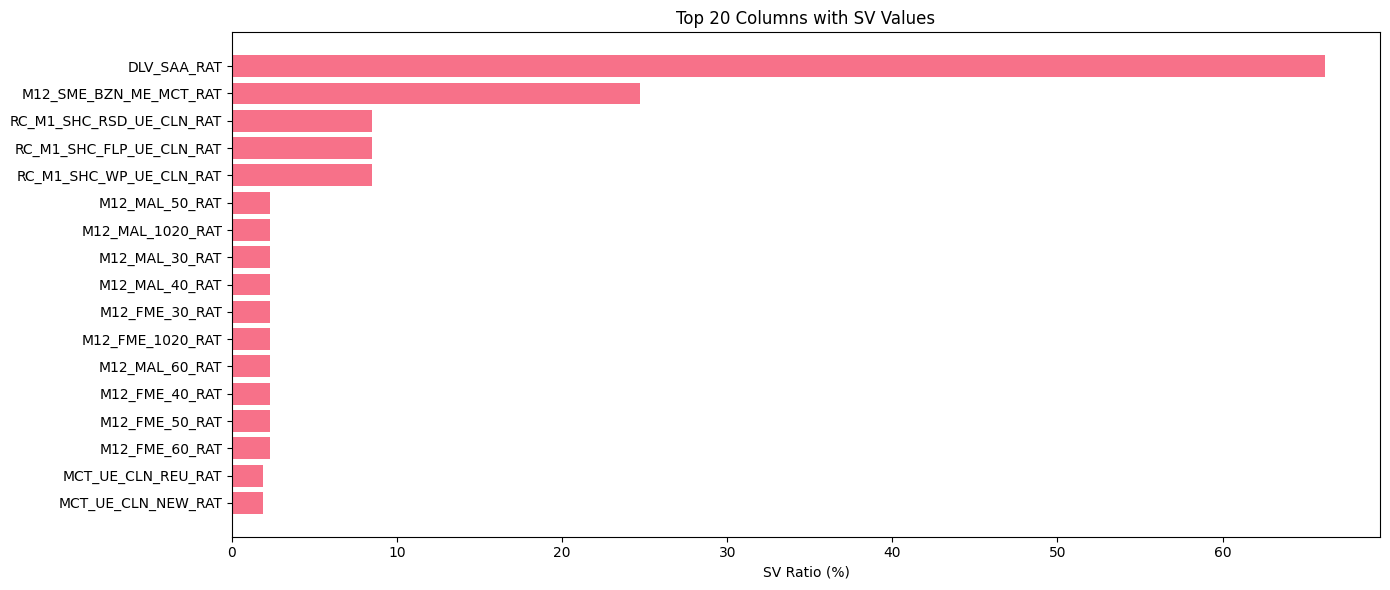

In [11]:
# SV 통계 확인
if not sv_stats.empty:
    print("\nTop 20 columns with SV:")
    display(sv_stats.head(20))
    
    # 시각화
    fig, ax = plt.subplots(figsize=(14, 6))
    top_sv = sv_stats.head(20)
    ax.barh(top_sv['column'], top_sv['sv_ratio'])
    ax.set_xlabel('SV Ratio (%)')
    ax.set_title('Top 20 Columns with SV Values')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [12]:
# SV를 NaN으로 변환
df_clean = handler.replace_sv_with_nan(df_merged)


Replacing SV (values <= -999999.0) with NaN...
Replaced 124,071 SV values with NaN


In [13]:
# 컬럼 타입 분류
column_types = handler.identify_column_types(df_clean)

print("\nColumn type details:")
for cat, cols in column_types.items():
    if cols:
        print(f"\n{cat.upper()}: {len(cols)} columns")
        print(f"  Examples: {cols[:5]}")


COLUMN TYPE CLASSIFICATION
DELIVERY: 1 columns
SALES: 4 columns
CUSTOMER: 1 columns
RATIO: 19 columns
CATEGORY: 2 columns
DATE: 3 columns
ID: 8 columns

Column type details:

DELIVERY: 1 columns
  Examples: ['DLV_SAA_RAT']

SALES: 4 columns
  Examples: ['RC_M1_SAA', 'M1_SME_RY_SAA_RAT', 'M12_SME_RY_SAA_PCE_RT', 'M12_SME_BZN_SAA_PCE_RT']

CUSTOMER: 1 columns
  Examples: ['RC_M1_UE_CUS_CN']

RATIO: 19 columns
  Examples: ['APV_CE_RAT', 'M1_SME_RY_CNT_RAT', 'M12_SME_RY_ME_MCT_RAT', 'M12_SME_BZN_ME_MCT_RAT', 'M12_MAL_1020_RAT']

CATEGORY: 2 columns
  Examples: ['RC_M1_TO_UE_CT', 'RC_M1_AV_NP_AT']

DATE: 3 columns
  Examples: ['TA_YM', 'ARE_D', 'MCT_ME_D']

ID: 8 columns
  Examples: ['ENCODED_MCT', 'MCT_OPE_MS_CN', 'MCT_BSE_AR', 'MCT_NM', 'MCT_BRD_NUM']


In [14]:
# 결측값 대체
df_imputed = handler.impute_missing_values(df_clean, column_types=column_types)


IMPUTING MISSING VALUES

Imputed 17 columns
Total null values filled: 124,071

Imputation summary by type:
type
delivery    57345
ratio       66726

Remaining null values: 187,172


In [15]:
# 대체 리포트 확인
imputation_report = handler.get_imputation_report()

if not imputation_report.empty:
    print("\nImputation Report (first 20):")
    display(imputation_report.head(20))


Imputation Report (first 20):


,column,method,value
0,DLV_SAA_RAT,zero,0.00000
1,M12_SME_BZN_ME_MCT_RAT,median,8.60000
2,M12_MAL_1020_RAT,median,9.89005
3,M12_MAL_30_RAT,median,12.50370
4,M12_MAL_40_RAT,median,9.44015
5,M12_MAL_50_RAT,median,8.99410
6,M12_MAL_60_RAT,median,5.03410
7,M12_FME_1020_RAT,median,7.05750
8,M12_FME_30_RAT,median,9.88735
9,M12_FME_40_RAT,median,6.78780


## 4. 구간 데이터 인코딩

In [16]:
# Feature Encoder 초기화
encoder = FeatureEncoder()

# 구간 변수 식별
interval_cols = encoder.identify_interval_columns(df_imputed)


Found 6 interval columns:
  - MCT_OPE_MS_CN
  - RC_M1_SAA
  - RC_M1_TO_UE_CT
  - RC_M1_UE_CUS_CN
  - RC_M1_AV_NP_AT
  - APV_CE_RAT


In [17]:
# 구간 변수 샘플 확인 (인코딩 전)
if interval_cols:
    sample_col = interval_cols[0]
    print(f"\nSample interval column: {sample_col}")
    print(f"Unique values:")
    print(df_imputed[sample_col].value_counts())


Sample interval column: MCT_OPE_MS_CN
Unique values:
MCT_OPE_MS_CN
3_25-50%              21812
4_50-75%              21567
5_75-90%              13454
2_10-25%              13119
1_10%이하                8691
6_90%초과(하위 10% 이하)     7947
Name: count, dtype: int64


In [18]:
# 모든 구간 변수 인코딩
df_encoded, encoded_cols = encoder.encode_all_interval_columns(df_imputed)


ENCODING INTERVAL COLUMNS

Found 6 interval columns:
  - MCT_OPE_MS_CN
  - RC_M1_SAA
  - RC_M1_TO_UE_CT
  - RC_M1_UE_CUS_CN
  - RC_M1_AV_NP_AT
  - APV_CE_RAT

Encoding 6 columns...

Successfully encoded 6 columns


In [19]:
# 인코딩 결과 확인
if encoded_cols:
    sample_col = encoded_cols[0]
    print(f"\nSample encoded column: {sample_col}")
    print(f"Unique values after encoding:")
    print(df_encoded[sample_col].value_counts().sort_index())


Sample encoded column: MCT_OPE_MS_CN
Unique values after encoding:
MCT_OPE_MS_CN
1     8691
2    13119
3    21812
4    21567
5    13454
6     7947
Name: count, dtype: int64


In [20]:
# 인코딩 요약
encoding_summary = encoder.get_encoding_summary(df_encoded, encoded_cols)

if not encoding_summary.empty:
    print("\nEncoding Summary (first 10):")
    display(encoding_summary.head(10))


Encoding Summary (first 10):


,column,unique_values,min,max,null_count,distribution
0,MCT_OPE_MS_CN,6,1.0,6.0,0,"{1: 8691, 2: 13119, 3: 21812, 4: 21567, 5: 134..."
1,RC_M1_SAA,6,1.0,6.0,0,"{1: 8799, 2: 13167, 3: 21800, 4: 21692, 5: 129..."
2,RC_M1_TO_UE_CT,6,1.0,6.0,0,"{1: 8719, 2: 13023, 3: 21981, 4: 21945, 5: 142..."
3,RC_M1_UE_CUS_CN,6,1.0,6.0,0,"{1: 8771, 2: 13147, 3: 21934, 4: 22026, 5: 140..."
4,RC_M1_AV_NP_AT,6,1.0,6.0,0,"{1: 8690, 2: 13143, 3: 21918, 4: 21781, 5: 128..."
5,APV_CE_RAT,6,1.0,6.0,6632,"{1.0: 52445, 2.0: 4994, 3.0: 5457, 4.0: 5551, ..."


## 5. 타겟 변수 생성

In [21]:
# 타겟 변수 생성
df_with_target = encoder.create_target_variables(
    df_encoded,
    close_date_col='MCT_ME_D',
    date_col='TA_YM',
    merchant_col='ENCODED_MCT'
)


CREATING TARGET VARIABLES

Closed merchants: 2,334 (2.70%)
Active merchants: 84,256 (97.30%)

------------------------------------------------------------
TARGET VARIABLE STATISTICS
------------------------------------------------------------
is_closed = 1: 2,334
will_close_1m = 1: 0
will_close_3m = 1: 0

Months until close (for closed merchants):
count    2334.000000
mean     -647.591688
std         6.874101
min      -659.000000
25%      -653.750000
50%      -648.000000
75%      -642.000000
max      -636.000000
Name: months_until_close, dtype: float64


In [22]:
# 타겟 변수 분포 확인
target_vars = ['is_closed', 'will_close_1m', 'will_close_3m']

print("\nTarget Variable Distribution:")
for var in target_vars:
    if var in df_with_target.columns:
        counts = df_with_target[var].value_counts()
        print(f"\n{var}:")
        print(counts)
        print(f"  Positive rate: {counts.get(1, 0) / len(df_with_target) * 100:.2f}%")


Target Variable Distribution:

is_closed:
is_closed
0    84256
1     2334
Name: count, dtype: int64
  Positive rate: 2.70%

will_close_1m:
will_close_1m
0    86590
Name: count, dtype: int64
  Positive rate: 0.00%

will_close_3m:
will_close_3m
0    86590
Name: count, dtype: int64
  Positive rate: 0.00%


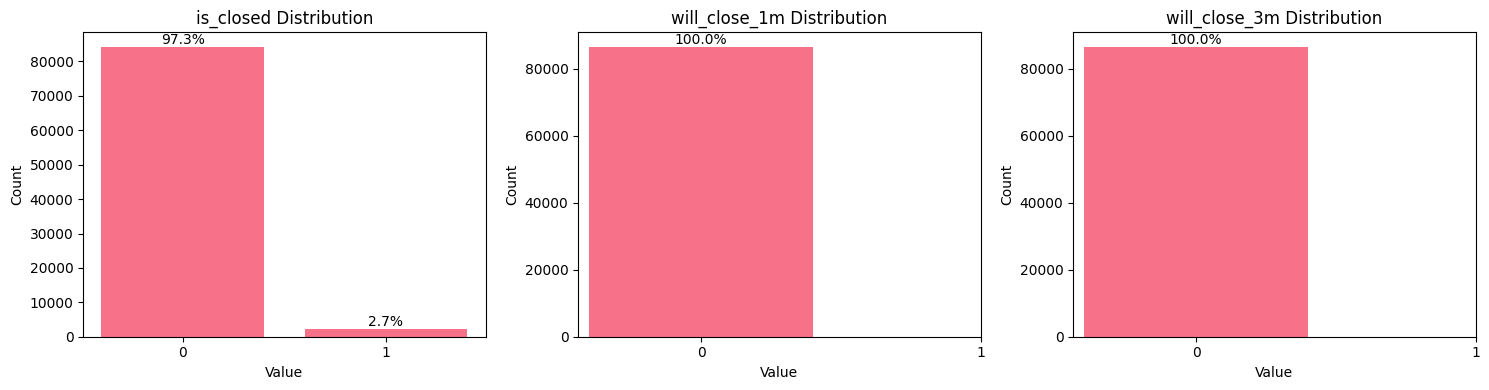

In [23]:
# 타겟 변수 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, var in enumerate(target_vars):
    if var in df_with_target.columns:
        counts = df_with_target[var].value_counts().sort_index()  # 0/1 순서 강제
        axes[i].bar(counts.index, counts.values)
        axes[i].set_title(f'{var} Distribution')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks([0, 1])  # 0/1 값만 표시
        
        # 비율 표시
        for j, (idx, val) in enumerate(counts.items()):
            ratio = val / len(df_with_target) * 100
            axes[i].text(j, val, f'{ratio:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Months Until Close (for closed merchants):
count    2334.000000
mean     -647.591688
std         6.874101
min      -659.000000
25%      -653.750000
50%      -648.000000
75%      -642.000000
max      -636.000000
Name: months_until_close, dtype: float64


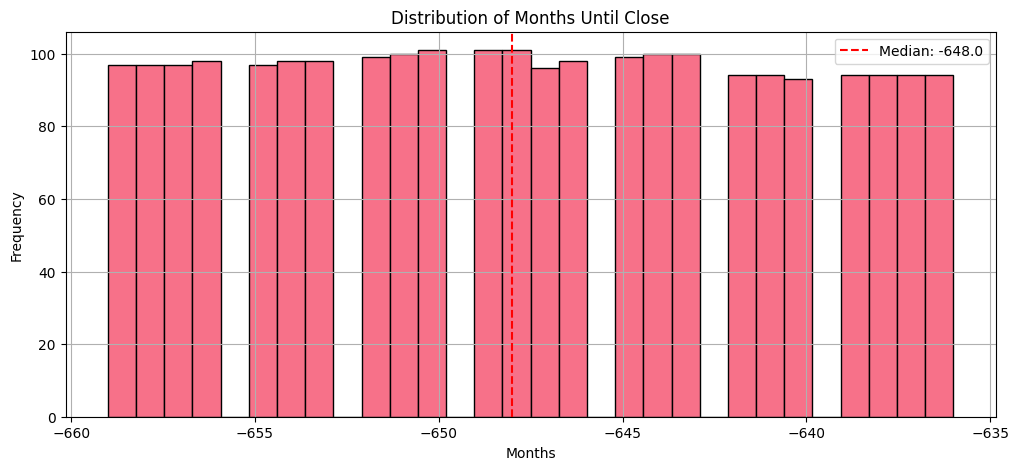

In [24]:
# months_until_close 분포 확인 (폐업 가맹점만)
if 'months_until_close' in df_with_target.columns:
    closed_data = df_with_target[df_with_target['is_closed'] == 1]['months_until_close']
    
    if len(closed_data.dropna()) > 0:
        print("\nMonths Until Close (for closed merchants):")
        print(closed_data.describe())
        
        # 히스토그램
        fig, ax = plt.subplots(figsize=(12, 5))
        closed_data.hist(bins=30, ax=ax, edgecolor='black')
        ax.set_title('Distribution of Months Until Close')
        ax.set_xlabel('Months')
        ax.set_ylabel('Frequency')
        ax.axvline(closed_data.median(), color='red', linestyle='--', label=f'Median: {closed_data.median():.1f}')
        ax.legend()
        plt.show()

## 6. 날짜 특성 추출

In [25]:
# 날짜 특성 추출
df_final = DateEncoder.extract_date_features(df_with_target, date_col='TA_YM')


Extracting date features from 'TA_YM'...
Created date features: year, month, quarter, month_sin, month_cos


In [26]:
# 날짜 특성 확인
date_features = ['year', 'month', 'quarter', 'month_sin', 'month_cos']

print("\nDate Features:")
for feat in date_features:
    if feat in df_final.columns:
        print(f"\n{feat}:")
        print(f"  Range: {df_final[feat].min()} ~ {df_final[feat].max()}")
        print(f"  Unique values: {df_final[feat].nunique()}")


Date Features:

year:
  Range: 2023 ~ 2024
  Unique values: 2

month:
  Range: 1 ~ 12
  Unique values: 12

quarter:
  Range: 1 ~ 4
  Unique values: 4

month_sin:
  Range: -1.0 ~ 1.0
  Unique values: 11

month_cos:
  Range: -1.0 ~ 1.0
  Unique values: 11


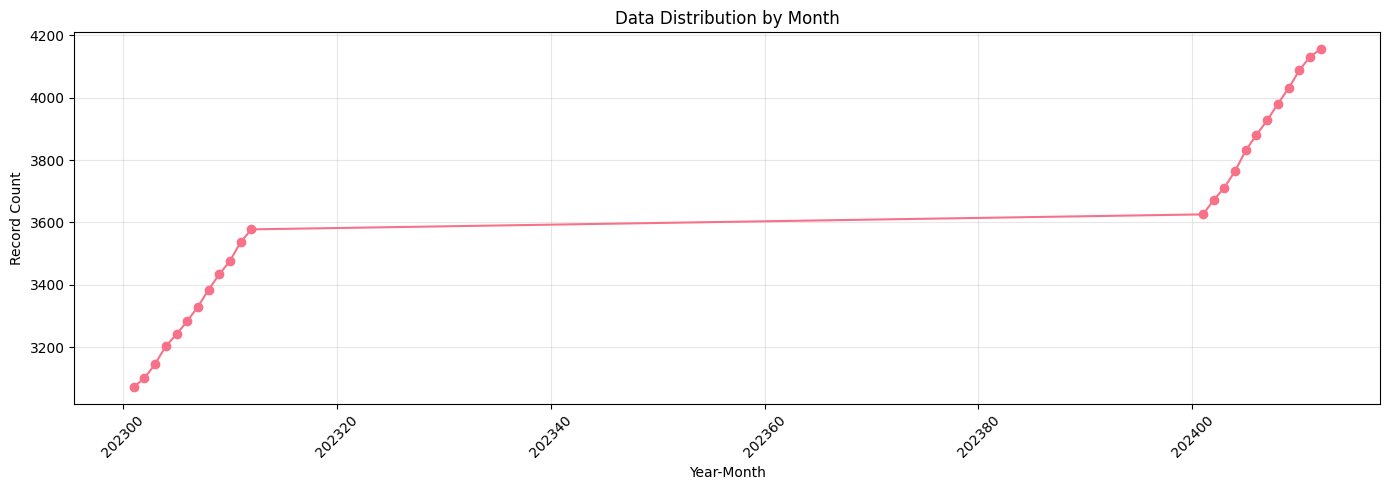

In [27]:
# 월별 데이터 분포
if 'TA_YM' in df_final.columns:
    monthly_counts = df_final['TA_YM'].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(monthly_counts.index, monthly_counts.values, marker='o')
    ax.set_title('Data Distribution by Month')
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Record Count')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 7. 전처리 결과 요약

In [28]:
# 최종 데이터 정보
print("="*80)
print("PREPROCESSING SUMMARY")
print("="*80)

print(f"\nFinal Shape: {df_final.shape}")
print(f"Total Columns: {len(df_final.columns)}")
print(f"Total Rows: {len(df_final):,}")
print(f"Unique Merchants: {df_final['ENCODED_MCT'].nunique():,}")
print(f"Date Range: {df_final['TA_YM'].min()} ~ {df_final['TA_YM'].max()}")
print(f"Memory Usage: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nMissing Values: {df_final.isnull().sum().sum():,}")
print(f"Duplicates: {df_final.duplicated().sum():,}")

PREPROCESSING SUMMARY

Final Shape: (86590, 47)
Total Columns: 47
Total Rows: 86,590
Unique Merchants: 4,185
Date Range: 202301 ~ 202412
Memory Usage: 73.75 MB

Missing Values: 271,428
Duplicates: 0


In [29]:
# 데이터 타입 분포
print("\nData Type Distribution:")
print(df_final.dtypes.value_counts())


Data Type Distribution:
float64    27
int64      10
object      7
int32       3
Name: count, dtype: int64


In [30]:
# 주요 컬럼 확인
print("\nKey Columns:")
key_cols = ['ENCODED_MCT', 'TA_YM', 'MCT_ME_D', 'is_closed', 'will_close_1m', 'will_close_3m']
available_keys = [col for col in key_cols if col in df_final.columns]

if available_keys:
    display(df_final[available_keys].head(10))


Key Columns:


,ENCODED_MCT,TA_YM,MCT_ME_D,is_closed,will_close_1m,will_close_3m
0,000F03E44A,202404,NaN,0,0,0
1,000F03E44A,202312,NaN,0,0,0
2,002816BA73,202404,NaN,0,0,0
3,002816BA73,202411,NaN,0,0,0
4,002816BA73,202406,NaN,0,0,0
5,002816BA73,202305,NaN,0,0,0
6,003473B465,202401,NaN,0,0,0
7,003AC99735,202311,NaN,0,0,0
8,003AC99735,202304,NaN,0,0,0
9,003AC99735,202411,NaN,0,0,0


## 8. 전처리 데이터 저장

In [31]:
# 전처리 데이터 저장
output_path = Path('../data/processed')
output_path.mkdir(exist_ok=True)

# CSV 저장
csv_path = output_path / 'preprocessed_data.csv'
df_final.to_csv(csv_path, index=False)
print(f"Saved to: {csv_path}")
print(f"File size: {csv_path.stat().st_size / 1024**2:.2f} MB")

# Parquet 저장 (옵션 - 더 효율적)
# parquet_path = output_path / 'preprocessed_data.parquet'
# df_final.to_parquet(parquet_path, index=False)
# print(f"Saved to: {parquet_path}")
# print(f"File size: {parquet_path.stat().st_size / 1024**2:.2f} MB")

Saved to: ../data/processed/preprocessed_data.csv
File size: 26.02 MB


In [32]:
# 메타데이터 저장
metadata = {
    'processing_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'shape': df_final.shape,
    'columns': list(df_final.columns),
    'dtypes': df_final.dtypes.astype(str).to_dict(),
    'interval_columns': encoded_cols,
    'target_variables': target_vars,
    'date_features': date_features,
    'date_range': (str(df_final['TA_YM'].min()), str(df_final['TA_YM'].max())),
    'unique_merchants': int(df_final['ENCODED_MCT'].nunique())
}

import json
metadata_path = output_path / 'preprocessing_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nMetadata saved to: {metadata_path}")


Metadata saved to: ../data/processed/preprocessing_metadata.json


## 9. 결론

### 완료된 작업
1. ✅ 3개 데이터셋 병합 완료
2. ✅ 결측값(SV) 감지 및 처리 완료
3. ✅ 구간 변수 인코딩 완료
4. ✅ 타겟 변수 생성 완료
5. ✅ 날짜 특성 추출 완료
6. ✅ 전처리 데이터 저장 완료

### 다음 단계 (Week 2)
- 시계열 Feature Engineering
  - Lag features (1, 3, 6, 12개월)
  - 이동평균 및 증감률
  - 추세/변동성 지표
  - 상대적 지표 (업종 내 순위 변화)
  - 고객 행동 지표
  - 복합 지표
  - Feature Selection

In [33]:
print("\n" + "="*80)
print("PREPROCESSING COMPLETED")
print("="*80)
print(f"\nFinal dataset: {df_final.shape}")
print(f"Saved to: {csv_path}")
print("\nReady for Feature Engineering!")


PREPROCESSING COMPLETED

Final dataset: (86590, 47)
Saved to: ../data/processed/preprocessed_data.csv

Ready for Feature Engineering!
